# Mapserver / Mapfile

In [1]:
from glob import glob
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from osgeo import gdal, osr
from rasterio.rio import convert

import fiona
import geopandas as gpd
import numpy as np
import os
import rasterio
import rasterio.plot
import rasterio.mask
# local
import AlertaDengue as alert_dengue

## Setting variables

In [2]:
shp_path = '%s/static/shapefile' % alert_dengue.__path__[0]
raster_dir_path = os.path.join(
    os.path.dirname(alert_dengue.__path__[0]),
    'tiffs'
)

# mapserver variables
ms_error_path = '/home/xmn/alerta_dengue_ms.log'
ms_cgi_path = 'http://localhost:81/cgi-bin/mapserv?map=%s&'
ms_mapfile_name = '%s.map'
ms_mapfile_dir = '%s/mapfiles/%%s' % (
    os.path.dirname(alert_dengue.__path__[0])
)

In [3]:
# Rio de Janeiro's conf
geocode = 3304557
city_name = 'Rio de Janeiro'
alert_level = 2
disease = 'dengue'

In [4]:
# gdal error handler
def error_handler(err_level, err_no, err_msg):
    if err_level >= gdal.CE_Warning:
        raise RuntimeError(err_level, err_no, err_msg)
    else: 
        print(err_msg)

gdal.PushErrorHandler(error_handler)
gdal.PopErrorHandler()

## Check Shapefile

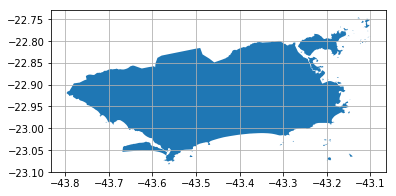

In [5]:
shapefile_path = os.path.join(shp_path, '%s.shp' % geocode)
gdf = gpd.GeoDataFrame.from_file(shapefile_path)
gdf.plot()

plt.grid(True)
plt.show()

In [6]:
# boundaries
gdf.bounds

,minx,miny,maxx,maxy
0,-43.796539,-23.082893,-43.099039,-22.74602


In [7]:
str_boundaries = [str(v) for v in gdf.bounds.iloc[0].values]
extent = ' '.join(str_boundaries)
extent_url = ','.join(str_boundaries)

In [8]:
# crs/srs
gdf.crs

{'init': 'epsg:4326'}

In [9]:
crs_proj = gdf.crs['init']
wms_srs = crs_proj.upper()

In [10]:
# using fiona to get coordintes
with fiona.open(shapefile_path, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

## Visualize raster images

In [11]:
def show_raster_info(src):
    """
    """
    try:
        for attr in dir(src):
            f = getattr(src, attr, None)
            
            if attr.startswith('_') or callable(f):
                continue
            
            print('=' * 80)
            print(attr)
            print(getattr(src, attr))
    except:
        pass
    
    print('=' * 80)
    for i in range(src.count):
        j = i+1
        print('colorinterp (%s):' % j, src.colorinterp(j))

    print('=' * 80)
    print('mask (dtype):', src.read_masks().dtype)

In [12]:
def show_raster_stats(src):
    """
    """
    print('=' * 80)
    print('dtypes:', src.dtypes)
    print('nodata:', src.nodata)
    for band in src.read():
        if np.isnan(band.min()):
            band = np.nan_to_num(band)
            
        print('min:', band.min())
        print('mean:', band.mean())
        print('median:', np.median(band))
        print('max:', band.max())
        

In [13]:
def get_raster_key(raster_name, to_lower=True):
    """
    """
    if raster_name[-14:].count('_') == 2:
        raster_key = raster_name[:-15]
    else:
        raster_key = raster_name[:-19]
    
    if to_lower:
        raster_key = raster_key.lower()
        
    return raster_key

In [14]:
data_range = {
    'ndvi': (-2000.0, +10000.0),
    'lst_day_1km': (0.0, 20000.0),
    'lst_night_1km': (-30.0, 30.0),
    'relative_humidity_2m_above_ground': (0.0, 100.0),
    'specific_humidity_2m_above_ground': (0.0, 1.0),
    'precipitation': (0, 200.0)
}

dtypes: ('float64',)
nodata: None
min: 0.0
mean: 10202.4544425
median: 15109.0
max: 16957.0
vmin: 0.0
vmax: 20000.0


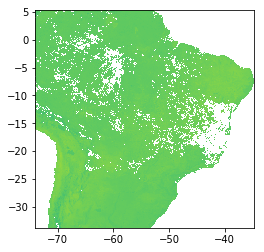

dtypes: ('float64',)
nodata: None
min: 5.72710565639
mean: 66.3202211507
median: 72.5043596392
max: 99.2469292494
vmin: 0.0
vmax: 100.0


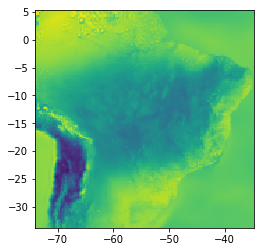

dtypes: ('float32',)
nodata: None
min: 0.0
mean: 13.8107
median: 4.93145
max: 158.266
vmin: 0
vmax: 200.0


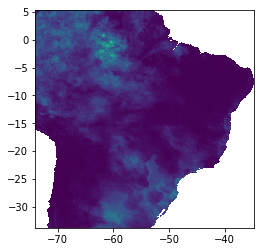

dtypes: ('float64',)
nodata: None
min: 0.000738002960603
mean: 0.0137487717319
median: 0.0150648173161
max: 0.0186948263513
vmin: 0.0
vmax: 1.0


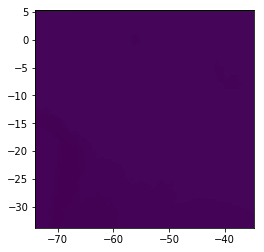

dtypes: ('float64',)
nodata: None
min: -22.05
mean: 8.96633672637
median: 0.0
max: 28.47
vmin: -30.0
vmax: 30.0


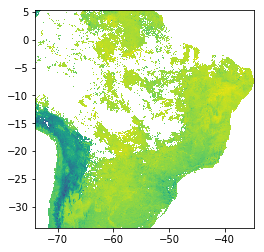

dtypes: ('float64',)
nodata: None
min: -2000.0
mean: 4845.03187485
median: 6308.0
max: 9743.0
vmin: -2000.0
vmax: 10000.0


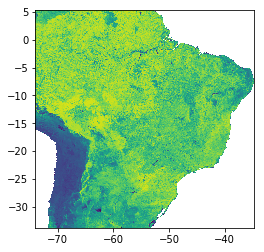

In [15]:
rasters = {}
str_numbers = ''.join([str(i) for i in range(10)])

for raster_file_path in glob(os.path.join(raster_dir_path, '*')):
    raster_name = raster_file_path.split(os.sep)[-1]

    if raster_name[0] in str_numbers or not raster_name[-3:] == 'tif':
        continue
        
    display(HTML('\n<H3>%s</H3>' % raster_name))
    
    """
    # force statistic computation
    ds = gdal.Open(raster_file_path, gdal.GA_Update)
    for i in range(1, ds.RasterCount+1):
        ds.GetRasterBand(i).ComputeStatistics(False)
    ds = None  # save, close
    """
    
    src = rasterio.open(raster_file_path)
    # show_raster_info(src)
    show_raster_stats(src)
    rasters[raster_name] = src
    
    raster_key = get_raster_key(raster_name)
    
    vmin = data_range[raster_key][0]
    vmax = data_range[raster_key][1]
    
    print('vmin:', vmin)
    print('vmax:', vmax)
    
    rasterio.plot.show(
        (src, 1), with_bounds=True, 
        vmin=vmin, vmax=vmax
    )

## Masking a raster using a shapefile

dtypes: ('float64',)
nodata: None
min: 0.0
mean: 5798.00735294
median: 0.0
max: 15780.0
vmin: 0.0
vmax: 20000.0


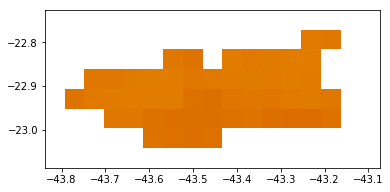

File saved!


dtypes: ('float64',)
nodata: None
min: 0.0
mean: 25.921494493
median: 0.0
max: 70.4929582014
vmin: 0.0
vmax: 100.0


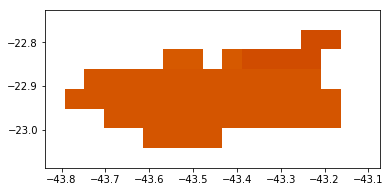

File saved!


dtypes: ('float32',)
nodata: None
min: 0.0
mean: 2.49168
median: 0.0
max: 8.93241
vmin: 0
vmax: 200.0


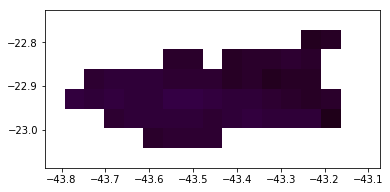

File saved!


dtypes: ('float64',)
nodata: None
min: 0.0
mean: 0.00550176733276
median: 0.0
max: 0.0149981212489
vmin: 0.0
vmax: 1.0


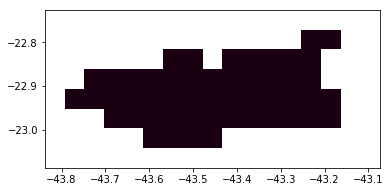

File saved!


dtypes: ('float64',)
nodata: None
min: 0.0
mean: 7.78683823529
median: 0.0
max: 22.87
vmin: -30.0
vmax: 30.0


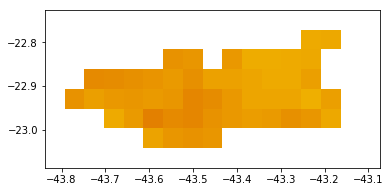

File saved!


dtypes: ('float64',)
nodata: None
min: 0.0
mean: 2126.66911765
median: 0.0
max: 8549.0
vmin: -2000.0
vmax: 10000.0


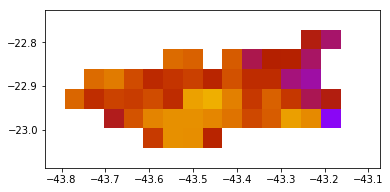

File saved!


In [16]:
new_rasters = {}

# https://mapbox.github.io/rasterio/topics/masking-by-shapefile.html
for raster_name, src in rasters.items():
    # make raster mask
    out_image, out_transform = rasterio.mask.mask(
        src, features, crop=True, nodata=np.nan
    )
    out_meta = src.meta.copy()
    
    img_type = out_image.dtype
    # cheating
    if img_type == np.float64:
        img_type = np.float64
    elif img_type == np.float32:
        img_type = np.float32
        
    raster_key = get_raster_key(raster_name)
        
    vmin = data_range[raster_key][0]
    vmax = data_range[raster_key][1]
    
    out_meta.update({
        'driver': "GTiff",
        'height': out_image.shape[1],
        'width': out_image.shape[2],
        'transform': out_transform,
        'dtype': img_type # out_images[raster_name].dtype
    })
    
    raster_new_name = '%s_%s' % (geocode, raster_name)
    
    display(HTML('\n<H3>%s</H3>' % raster_new_name))
    
    output_path = os.path.join(raster_dir_path, raster_new_name)
    new_rasters[raster_new_name] = raster_dir_path
    
    with rasterio.open(output_path, "w", **out_meta) as dst:
        dst.write(out_image)
        show_raster_stats(dst)
        
        print('vmin:', vmin)
        print('vmax:', vmax)
        
        rasterio.plot.show(
            (dst, 1), with_bounds=True, cmap='gnuplot',
            vmin=vmin, vmax=vmax
        )

    # src.close()
    print('File saved!')

## Convert data to uint8

Original min=14988.000, Original max=15780.000
rows =  8 columns =  17
--------------------------------------------------------------------------------
dtypes: ('uint8',)
--------------------------------------------------------------------------------
dtypes: ('uint8',)
nodata: None
min: 0
mean: 95.625
median: 0.0
max: 255


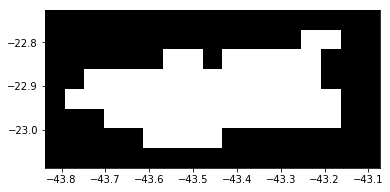

Original min=0.000, Original max=70.493
rows =  8 columns =  17
--------------------------------------------------------------------------------
dtypes: ('uint8',)
--------------------------------------------------------------------------------
dtypes: ('uint8',)
nodata: None
min: 0
mean: 25.9117647059
median: 0.0
max: 70


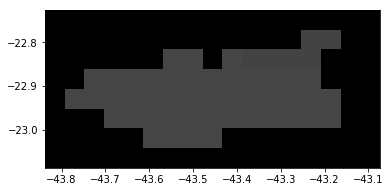

Original min=3.174, Original max=8.932
rows =  8 columns =  17
--------------------------------------------------------------------------------
dtypes: ('uint8',)
--------------------------------------------------------------------------------
dtypes: ('uint8',)
nodata: None
min: 0
mean: 2.47794117647
median: 0.0
max: 9


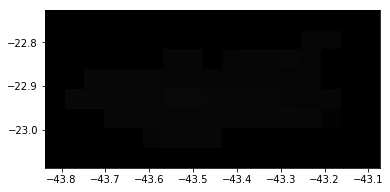

Original min=0.000, Original max=0.015
rows =  8 columns =  17
--------------------------------------------------------------------------------
dtypes: ('uint8',)
--------------------------------------------------------------------------------
dtypes: ('uint8',)
nodata: None
min: 0
mean: 0.0
median: 0.0
max: 0


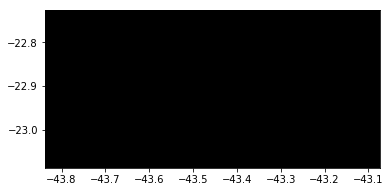

Original min=17.730, Original max=22.870
rows =  8 columns =  17
--------------------------------------------------------------------------------
dtypes: ('uint8',)
--------------------------------------------------------------------------------
dtypes: ('uint8',)
nodata: None
min: 0
mean: 7.79411764706
median: 0.0
max: 23


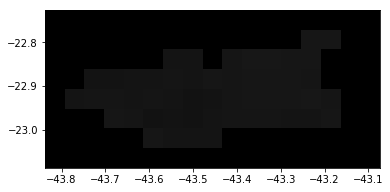

Original min=0.000, Original max=8549.000
rows =  8 columns =  17
--------------------------------------------------------------------------------
dtypes: ('uint8',)
--------------------------------------------------------------------------------
dtypes: ('uint8',)
nodata: None
min: 0
mean: 95.625
median: 0.0
max: 255


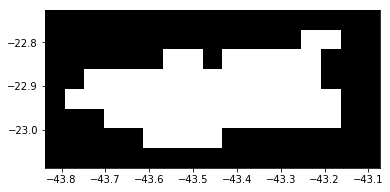

In [17]:
# https://gis.stackexchange.com/questions/143584/
# convert-a-tiff-float32-image-to-8bit-tif-or-jpeg-image-using-gdal-and-python
for raster_name, raster_path in new_rasters.items():
    raster_new_name = '8bits_%s' % raster_name
    display(HTML('\n<H3>%s</H3>' % raster_new_name))
    
    input_path = os.path.join(raster_dir_path, raster_name)
    output_path = os.path.join(raster_dir_path, raster_new_name)
    
    dataset = gdal.Open(input_path)

    geotransform = dataset.GetGeoTransform()
    prj=dataset.GetProjection()
    values = dataset.ReadAsArray()
    band = dataset.GetRasterBand(1)

    #Get minimum and maximum values of raster
    min = band.GetMinimum()
    max = band.GetMaximum()

    #if not exist minimum and maximum values
    if min is None or max is None:
        (min,max) = band.ComputeRasterMinMax(1)

    print("Original min=%.3f, Original max=%.3f" % (min,max))

    # Set output file
    output_file = output_path

    # Create new GTiff (Byte type)
    driver = gdal.GetDriverByName("GTiff")
    dst_ds = driver.Create(
        output_file, band.XSize, band.YSize, 1, gdal.GDT_Byte
    )

    print("rows = ", band.YSize, "columns = ", band.XSize)
    
    for i in range(band.YSize):
        for j in range(band.XSize):
            values[i][j]

    dst_ds.GetRasterBand(1).WriteArray(values)

    # top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
    dst_ds.SetGeoTransform([
        geotransform[0], geotransform[1], 0, 
        geotransform[3], 0, geotransform[5]
    ])

    # set projection of new raster
    dst_ds.SetProjection(prj)

    dst_ds = None
    dataset = None
    
    with rasterio.open(output_path) as src:
        # show_raster_info(src)
        print('-' * 80)
        print('dtypes:', src.dtypes)
        print('-' * 80)
        
        show_raster_stats(src)
        
        rasterio.plot.show(
            (src, 1), with_bounds=True, cmap='gray',
            vmin=0, vmax=255
        )

## Boundaries

In [18]:
# raster_layer_bounds
# BoundingBox(
#  left=-74.02117941144857, 
#  bottom=-33.776654682894005, 
#  right=-34.76480149542548, 
#  top=5.300060176305177)
bounds = rasters['NDVI_2010_12_19.tif'].bounds
# leaflet bounds ex: [[40.712216, -74.22655], [40.773941, -74.12544]];
raster_layer_bounds = [[bounds[0], bounds[1]], [bounds[2], bounds[3]]]
raster_layer_bounds

[[-74.02117941144857, -33.776654682894005],
 [-34.76480149542548, 5.300060176305177]]

## Creating Mapfile for raster image

In [19]:
# mapfile templates

mapfile_template = '''
MAP
    # The geographic extent (the rectangular area covered by the map) is 
    # defined by the keyword EXTENT. The rectangular area is specified by
    # the coordinates of the opposite corners (the lower left and the upper 
    # right). These are coordinates of the southwest and the northeast corners 
    # EX:
    # EXTENT -125.00 20.00 -65.00 50.00
    # The geographic extent stretches from 125° west, 20° north to 65° west, 
    # 50° north.
    
    CONFIG 'ON_MISSING_DATA' 'IGNORE'
    CONFIG 'PROJ_LIB' './conf/'
    CONFIG      "MS_ERRORFILE" "%(ms_error_path)s"
    CONFIG      "CPL_DEBUG" "ON"
    CONFIG      "PROJ_DEBUG" "ON"
    DEBUG       5
    
    NAME        "MAP_%(mapfile_name)s"
    
    IMAGETYPE   png
    IMAGECOLOR  0 0 0
    MAXSIZE     4000
    SIZE        800 800
    UNITS       meters
    EXTENT %(extent)s
       
    OUTPUTFORMAT
      NAME      "png"
      DRIVER    AGG/PNG
      MIMETYPE  "image/png"
      IMAGEMODE RGBA
      EXTENSION "png"
      FORMATOPTION "GAMMA=0.75"
    END
    
    # OUTPUTFORMAT
    #   NAME "GTiff"
    #   DRIVER GDAL/GTiff
    #   MIMETYPE "image/tiff"
    #   IMAGEMODE RGBA
    #   EXTENSION "tif"
    # END
    
    # OUTPUTFORMAT
    #   NAME "kml"
    #   DRIVER KML
    #   MIMETYPE "application/vnd.google-earth.kml.xml"
    #   IMAGEMODE RGBA
    #   EXTENSION "kml"
    # END

    PROJECTION
        "init=%(crs_proj)s"
    END
    
    SHAPEPATH '%(shape_path)s'

    WEB
      METADATA
        "wms_title" "Alerta Dengue"
        "wms_onlineresource" "%(ms_cgi_path)s"
        "wms_enable_request" "*"
        "wms_srs" "%(wms_srs)s EPSG:3857"
        "labelcache_map_edge_buffer" "-10"
        # "wms_feature_info_mime_type" "text/html"
        # "wms_format" "image/png"
      END
      
      IMAGEPATH '/tmp/map/'
      IMAGEURL '/mapimg/'

    END
 
%(include_layers)s
 
END
'''

mapfile_layer_template = '''
    LAYER
        NAME         "%(city_name)s"
        DATA         "%(raster_path)s"
        STATUS       DEFAULT # ON
        TYPE         RASTER
        OFFSITE      0 0 0
        
        TEMPLATE "conf/template.html"
        
        PROJECTION
          "init=%(crs_proj)s"
        END
        
        METADATA
          "wms_title" "%(city_name)s"
          "wms_srs" "%(wms_srs)s EPSG:3857"
          "wms_include_items" "all" 
        END
        
        COMPOSITE
            OPACITY 70
        END # COMPOSITE
        
        CLASS 
         NAME "class_hotcolors" 
         STYLE 
            RANGEITEM "style_hotcolors" 
            COLORRANGE  255 255 255  255 0 0
            DATARANGE %(vmin)s %(vmax)s
         END # STYLE 

       END # CLASS 
    END
'''

In [20]:
shape_path = raster_dir_path
layers = []

for raster_name, src in rasters.items():
    raster_file_name = '%s_%s' % (geocode, raster_name)
    layer_name = '%s.map' % geocode

    raster_title = get_raster_key(raster_name, False)
    raster_key = raster_title.lower()
        
    vmin = data_range[raster_key][0]
    vmax = data_range[raster_key][1]
    
    layer_conf = {
        'geocode': geocode,
        'city_name': city_name.upper().replace(' ', '_'),
        'layer_name': layer_name,
        'rgb': '#FF9900',
        'wms_srs': wms_srs,
        'crs_proj': crs_proj,
        'raster_path': raster_file_name,
        'vmin': vmin,
        'vmax': vmax,
        'raster_title': raster_title
    }
    
    layers += [layer_conf]

In [21]:
# save individual layers
for layer_conf in layers:
    include_layers = ''
    
    layer_content = mapfile_layer_template % layer_conf
    layer_relative_path = os.path.join(
        'layers/meteorological',
        layer_conf['raster_title'],
        layer_conf['layer_name']
    )
    
    layer_path = ms_mapfile_dir % layer_relative_path
    
    include_layers += (
        'INCLUDE "%s"' % layer_relative_path
    )
    
    layer_path_dir = os.path.dirname(layer_path)

    if not os.path.exists(layer_path_dir):
        os.makedirs(layer_path_dir)
    
    with open(layer_path, 'w') as f:
        f.write(layer_content)

    mapfile_name = '%s.map' % layer_conf['raster_title']
    mapfile_path = ms_mapfile_dir % mapfile_name

    ms_config = {
        'include_layers': include_layers,
        'ms_error_path': ms_error_path,
        'ms_cgi_path': ms_cgi_path % mapfile_path,
        'shp_path': shp_path,
        'extent': '-44.8893205505 -23.3689319629 -40.9585185182 -20.763205462',
        'mapfile_name': 'NDVI',
        'wms_srs': wms_srs,
        'crs_proj': crs_proj,
        'shape_path': shape_path
    }

    mapfile_content = mapfile_template % ms_config

    print('Saving ', mapfile_path, 'file ...')
    with open(mapfile_path, 'w') as f:
        f.write(mapfile_content)

Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/LST_Day_1km.map file ...
Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/relative_humidity_2m_above_ground.map file ...
Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/Precipitation.map file ...
Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/specific_humidity_2m_above_ground.map file ...
Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/LST_Night_1km.map file ...
Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/NDVI.map file ...


## Visualizing the map

In [22]:
HTML('''
<script type="text/javascript">
    var extent_url = '%s';
    var crs_proj = '%s';
    var raster_layer_bounds = %s;
</script>
''' % (extent_url, crs_proj, raster_layer_bounds))

In [23]:
%%html

<div id="alerta_dengue" style="height: 400px; width: 800px;"></div>

<link rel="stylesheet" href="lib/leaflet/leaflet.css" />
<script type="text/javascript" src="lib/leaflet/leaflet.js"></script>

<script>

var mapfile_url = (
    'http://localhost:81/cgi-bin/mapserv?' + 
    'map=/var/www/mapserver/mapfiles/dengue.map&' + 
    'SERVICE=WMS&VERSION=1.1.1&REQUEST=GetMap&LAYERS=RIO_DE_JANEIRO&' +
    'STYLES=&SRS=' + crs_proj + '&BBOX=' + extent_url + '&' +
    'WIDTH=400&HEIGHT=300&FORMAT=image/png'
);

var mapfile_raster_url = (
    'http://localhost:81/cgi-bin/mapserv?' + 
    'map=/var/www/mapserver/mapfiles/%(map_name)s.map&' + 
    'SERVICE=WMS&VERSION=1.1.1&REQUEST=GetMap&LAYERS=RIO_DE_JANEIRO&' +
    'STYLES=&SRS=' + crs_proj + '&BBOX=' + extent_url + '&' +
    'WIDTH=400&HEIGHT=300&FORMAT=image/png'
);

var osmUrl='http://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png';
var osmAttrib = 'Map data © <a href="http://openstreetmap.org">OpenStreetMap</a> contributors';

var raster_url = '';
var raster_layer;
var geocode = '3304557';

var minZoom = 9;
var maxZoom = 11;
var zoom = 10;

//# openstreetmap
var osm = L.tileLayer(osmUrl, {
    attribution: osmAttrib,
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom
});

var baseMap = {"OSM": osm};

var map = L.map(
    'alerta_dengue', {
        //crs: L.CRS.EPSG4326,
        center: new L.LatLng(-22.9192,-43.4441),
        zoom: zoom,
        layers: [osm]
    }
); 

//# mapserver shapefile
var ms_shapefile = L.tileLayer.wms(mapfile_url, {
    layers: 'RIO_DE_JANEIRO',
    format: 'image/png',
    transparent: true,
    attribution: "Info Dengue",
    srs:"EPSG:4326",
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom,
});

// raster_layer_bounds = [[40.712216, -74.22655], [40.773941, -74.12544]];
// map.getBounds();
console.log(raster_layer_bounds);

//# mapserver raster
var raster_conf = {
    layers: 'RIO_DE_JANEIRO',
    format: 'image/png',
    transparent: true,
    attribution: "Info Dengue",
    srs:"EPSG:4326",
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom,
};

var ms_rasters = {
    'NDVI': null,
    'LST_Day_1km': null,
    'LST_Night_1km': null,
    'relative_humidity_2m_above_ground': null,
    'specific_humidity_2m_above_ground': null,
    'Precipitation': null
}

var raster_name;
var overlayMaps = {
    'Rio de Janeiro': ms_shapefile,
};
var url = '';
for (raster_name in ms_rasters){
    url = mapfile_raster_url.replace('%(map_name)s', raster_name);
    console.log(url);
    ms_rasters[raster_name] = L.tileLayer.wms(url, raster_conf);
    overlayMaps[raster_name] = ms_rasters[raster_name];
}

ms_rasters['NDVI'].addTo(map);
ms_shapefile.addTo(map);

L.control.layers(baseMap, overlayMaps).addTo(map);

</script>